<a href="https://colab.research.google.com/github/sourishdey2005/Hybrid-Quantum-Classical-Framework-for-AI-Generated-Text-Detection-Using-Quantum-Feature-Encoding/blob/main/Text_Detection_Using_Quantum_Feature_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-machine-learning
!pip install quantumlib
!pip install numpy pandas matplotlib seaborn
!pip install scikit-learn nltk spacy
!pip install torch
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for quantumlib: filename=quantumlib-0.0.106-py3-none-any.whl size=2705 sha256=325497c4cbf0b868df687e81c7bed0185e32584005833ecd209d70660ac27c28
  Stored in directory: /root/.cache/pip/wheels/c5/e6/9d/b0cf5361b9ba58ba7008fc0880a1c1eb683124148cacb50e44
Successfully built quantumlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do t

In [1]:
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')

import spacy
nlp = spacy.load("en_core_web_sm")

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
import torch.nn as nn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
def generate_ai_text():
    base = [
        "This concept highlights the importance of understanding system dynamics",
        "In conclusion, the results demonstrate significant improvements",
        "Furthermore, it is essential to consider multiple perspectives"
    ]
    return " ".join(random.choices(base, k=random.randint(3,6)))

def generate_human_text():
    base = [
        "I honestly think this feels a bit weird to explain",
        "Not sure why, but this part really confused me",
        "I messed this up earlier, so let me try again"
    ]
    noise = ''.join(random.choices(string.punctuation, k=random.randint(1,3)))
    return " ".join(random.choices(base, k=random.randint(2,5))) + noise

def create_dataset(n=5000):
    texts, labels = [], []
    for _ in range(n):
        texts.append(generate_ai_text())
        labels.append(1)
        texts.append(generate_human_text())
        labels.append(0)
    return pd.DataFrame({"text": texts, "label": labels})

df = create_dataset(5000)


In [5]:
nltk.download('punkt_tab')
def extract_features(text):
    tokens = word_tokenize(text)
    sents = sent_tokenize(text)
    doc = nlp(text)

    f1 = len(tokens)                            # token count
    f2 = len(set(tokens)) / (len(tokens)+1)    # lexical diversity
    f3 = np.mean([len(s) for s in sents]) if sents else 0
    f4 = sum(1 for t in doc if t.pos_ == "VERB")
    f5 = sum(1 for t in doc if t.dep_ == "nsubj")
    f6 = len(FreqDist(tokens))                  # vocab entropy proxy
    f7 = text.count(",")
    f8 = text.count(".")

    return [f1,f2,f3,f4,f5,f6,f7,f8]

X = np.array([extract_features(t) for t in df.text])
y = df.label.values

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)


In [7]:
def quantum_circuit(n_qubits=4):
    params = [Parameter(f"θ{i}") for i in range(n_qubits)]
    qc = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        qc.ry(params[i], i)

    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    return qc, params

qc, params = quantum_circuit()


In [8]:
qnn = EstimatorQNN(
    circuit=qc,
    input_params=params,
    weight_params=[],
    input_gradients=True
)

model = TorchConnector(qnn)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

for epoch in range(30):
    optimizer.zero_grad()
    preds = torch.sigmoid(model(X_train_t))
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.4f}")


Epoch 0 | Loss 0.6941
Epoch 5 | Loss 0.6941
Epoch 10 | Loss 0.6941
Epoch 15 | Loss 0.6941
Epoch 20 | Loss 0.6941
Epoch 25 | Loss 0.6941


In [11]:
with torch.no_grad():
    preds = torch.sigmoid(model(X_test_t)).numpy().flatten()
    preds_bin = (preds > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, preds_bin))
print(classification_report(y_test, preds_bin))


Accuracy: 0.5495
              precision    recall  f1-score   support

           0       0.61      0.27      0.37      1000
           1       0.53      0.83      0.65      1000

    accuracy                           0.55      2000
   macro avg       0.57      0.55      0.51      2000
weighted avg       0.57      0.55      0.51      2000



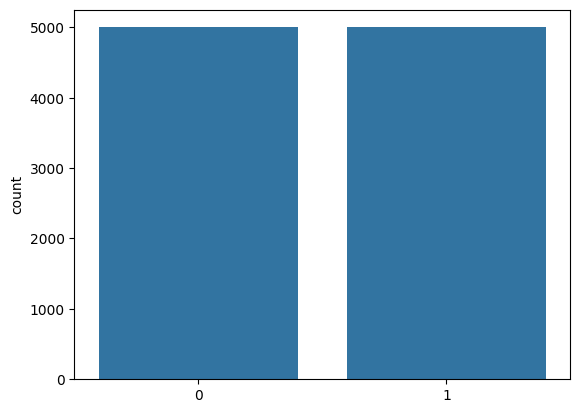

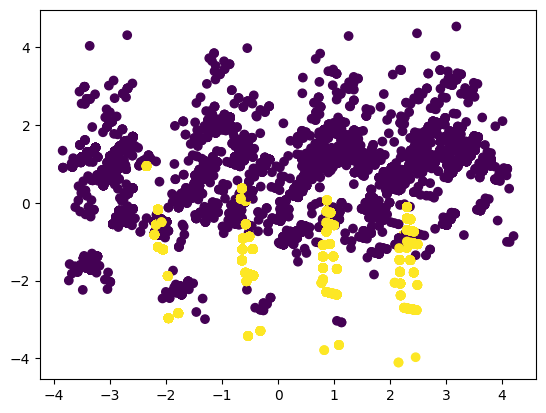

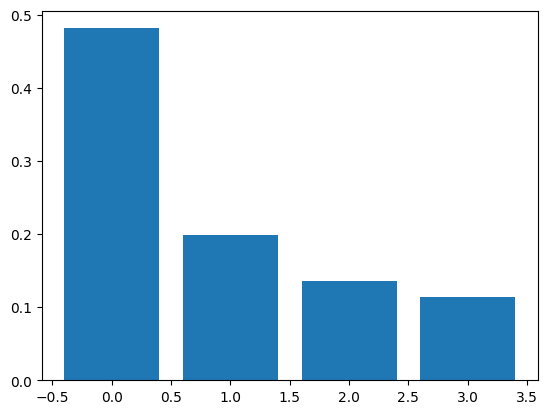

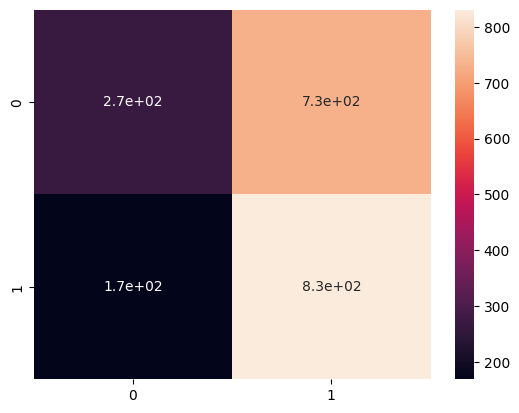

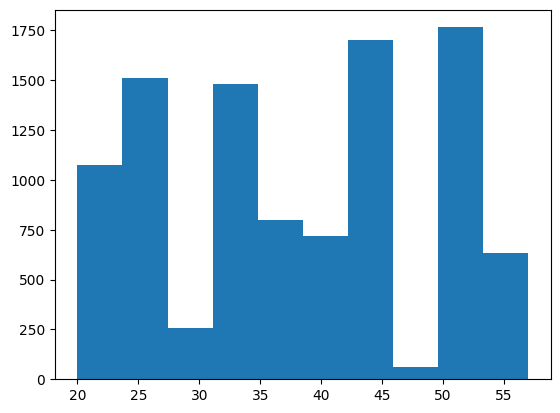

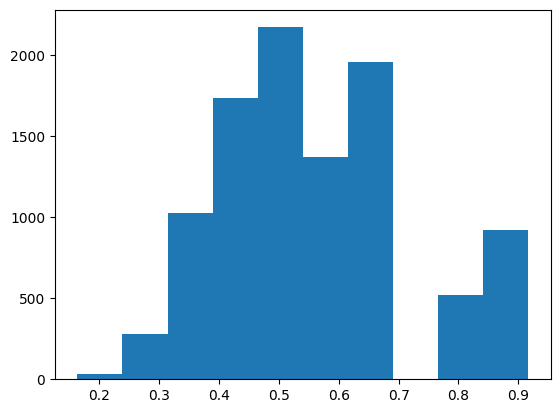

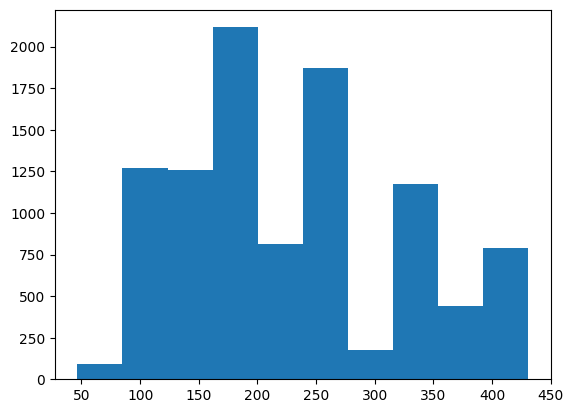

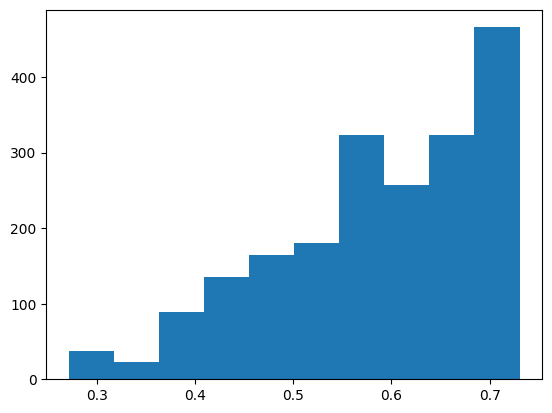

In [16]:
!pip install pylatexenc

#  Label distribution
sns.countplot(x=y)
plt.show()

#  PCA scatter
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.show()

#  Feature importance (variance)
plt.bar(range(4), pca.explained_variance_ratio_)
plt.show()

#  Confusion matrix
sns.heatmap(confusion_matrix(y_test, preds_bin), annot=True)
plt.show()

#  Token length distribution
plt.hist(X[:,0])
plt.show()

#  Lexical diversity
plt.hist(X[:,1])
plt.show()

#  Sentence length
plt.hist(X[:,2])
plt.show()

#  Prediction probability
plt.hist(preds)
plt.show()



In [ ]:
def predict_text(text):
    feat = extract_features(text)
    feat = scaler.transform([feat])
    feat = pca.transform(feat)
    feat_t = torch.tensor(feat, dtype=torch.float32)

    with torch.no_grad():
        p = torch.sigmoid(model(feat_t)).item()

    return p

while True:
    txt = input("\nEnter text (or type exit): ")
    if txt.lower() == "exit":
        break

    prob = predict_text(txt)
    print("AI-Generated Probability:", round(prob,3))
    print("Prediction:", "AI Generated" if prob > 0.5 else "Human Written")



Enter text (or type exit): This is the process of deciding "what to do". It focuses on "Right Understanding" to identify basic human aspirations like continuous happiness and prosperity. It provides the vision and moral compass for life
AI-Generated Probability: 0.517
Prediction: AI Generated

Enter text (or type exit): i love u 
AI-Generated Probability: 0.53
Prediction: AI Generated

Enter text (or type exit): hem sheela
AI-Generated Probability: 0.438
Prediction: Human Written

Enter text (or type exit): jalwa
AI-Generated Probability: 0.4
Prediction: Human Written

Enter text (or type exit): hello
AI-Generated Probability: 0.4
Prediction: Human Written

Enter text (or type exit): This focuses on "how to do". It provides the techniques, methods, and practical "know-how" to execute tasks, such as engineering, coding, or medical procedures.
AI-Generated Probability: 0.728
Prediction: AI Generated
